In [58]:
import sys
import platform
import json
import pickle
import time
import itertools

from textblob import TextBlob
from wordcloud import WordCloud
from pathlib import Path
import tweepy
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import gmplot
import matplotlib.pyplot as plt

import configparser

tweepy.debug(True) # show the rate limit information

DATA_DIR = Path('data') / '11-18_data'
RESULTS_PER_QUERY = 100 

import seaborn as sns
sns.set()
sns.set_style('darkgrid')


# needed for .parquet files
!pip install pyarrow 
!pip install jupyternotify
# import nltk
# nltk.download('wordnet')

%load_ext jupyternotify

Error processing line 7 of c:\users\tommy\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "c:\users\tommy\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


Error processing line 7 of c:\users\tommy\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "c:\users\tommy\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


# Load Twitter Data

Load the data from each search using the methods built in to the TwitterTrawler class.

there are ~352 columns, but many of them are not useful. I flattened the .json so everything is appended as . (attributes of `place` are named `place.attr1, place.attr2...`). Explore which have numeric data etc to plot, check out geo columns, read the documentation.

`corona` is a bit of a weird query, it returns many many retweets and results but not sure if it all has to do with coronavirus.

In [51]:
dfs = {}
for fname in DATA_DIR.glob('*.pkl'):
    print(f'Reading data from {fname}')
    dfs[fname.name.split('_')[0]] = pd.read_pickle(fname)
    
df = pd.concat(dfs.values(), axis=0)

# add the user query as a data attribute
df['query'] = list(itertools.chain.from_iterable([[key]*len(value) for key, value in dfs.items()]))

 # drop duplicate tweets
df = df.drop(df.index[df.index.duplicated()])

assert df.index.duplicated().sum() == 0
print(f'Loaded data for queries {list(dfs.keys())}')

Reading data from data\11-18_data\coronavirus_11_to_18_10000.pkl
Reading data from data\11-18_data\coronavirus_11_to_18_100000.pkl
Reading data from data\11-18_data\corona_11_to_18_10000.pkl
Reading data from data\11-18_data\COVID-19_11_to_18_10000.pkl
Reading data from data\11-18_data\COVID19_11_to_18_10000.pkl
Reading data from data\11-18_data\COVID_19_11_to_18_10000.pkl
Loaded data for queries ['coronavirus', 'corona', 'COVID-19', 'COVID19', 'COVID']


# Selection

Partially manual, partially automated data selection procedure. Look at what is informative, what you need, and what might have potential for linear correlation.

todo:
- correlation plots
- bar plots for cat. vars


In [52]:
for item in df.columns:
    print(item)   

created_at
id
id_str
full_text
truncated
display_text_range
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
quoted_status_id
quoted_status_id_str
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
metadata.iso_language_code
metadata.result_type
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.pro

In [53]:
# manually select some columns
selected_data = {'id', 'user.location', 'place', 'retweet_count', 'full_text', 'user.name', 'created_at'}

drop_threshold = 0.2 # threshold for % of missing values to drop a column

# cut columns with too many NaN
cols = set(df.columns[df.isna().sum() / len(df) <= drop_threshold])

# get all numerical columns
numeric = set(df._get_numeric_data().columns)

# columns related to place
place_cols = set([value for value in df.columns if value[:5] == 'place'])

The plot here looks very different depending on whether you include labels other than `coronavirus`.

saving fig


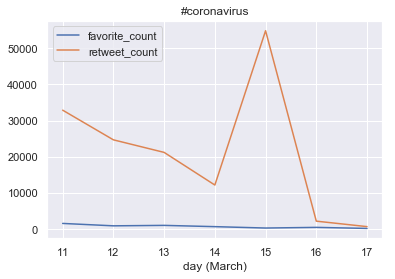

saving fig


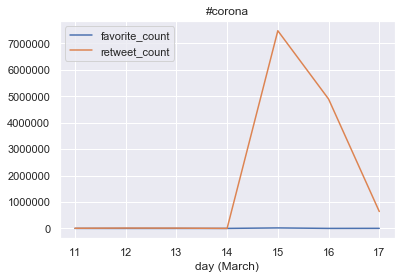

saving fig


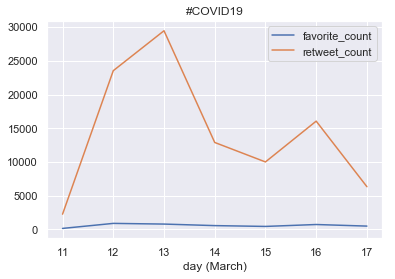

In [54]:
# take all selected columns and all numeric
cols = cols.intersection(numeric).union(selected_data)

# aggregate some selected counts
for level in df['query'].unique():
    query_counts = df[cols][df['query']==level]
    
    counts_by_day = query_counts.groupby(by=query_counts.index.day).sum()

    counts_by_day[['favorite_count', 'retweet_count']].plot()
    plt.title(f'#{level}')
    plt.xlabel('day (March)')
    print('saving fig')
    plt.savefig(f'fav_rt_{level}.png')

    plt.show()

# Load CSSE Data

Not yet implemented.

# Geolocation

Add in Ersin's script for adding the geocode here and add it to the data.

In [55]:
import pandas as pd
from pathlib import Path
import numpy as np
from geopy.geocoders import Nominatim

dfs = {}
for fname in (DATA_DIR / '11-18_data').glob('*.pkl'):
    print(f'Reading data from {fname}')
    dfs[fname.name.split('_')[0]] = pd.read_pickle(fname)
    break

print(df['user.geo_enabled'])
result = df['user.location'].mask(df['user.geo_enabled'], other=np.nan)

result

created_at
2020-03-17 23:57:17+00:00    False
2020-03-17 23:39:11+00:00    False
2020-03-17 23:09:38+00:00     True
2020-03-17 23:08:22+00:00     True
2020-03-17 22:59:31+00:00    False
                             ...  
2020-03-11 05:37:12+00:00     True
2020-03-11 03:39:12+00:00    False
2020-03-11 03:32:12+00:00     True
2020-03-11 01:24:19+00:00    False
2020-03-11 00:10:20+00:00    False
Name: user.geo_enabled, Length: 14609, dtype: bool


created_at
2020-03-17 23:57:17+00:00            Land of Oz
2020-03-17 23:39:11+00:00        Pittsburgh, PA
2020-03-17 23:09:38+00:00                   NaN
2020-03-17 23:08:22+00:00                   NaN
2020-03-17 22:59:31+00:00    Hasihezihaziberria
                                    ...        
2020-03-11 05:37:12+00:00                   NaN
2020-03-11 03:39:12+00:00            Texas, USA
2020-03-11 03:32:12+00:00                   NaN
2020-03-11 01:24:19+00:00                 India
2020-03-11 00:10:20+00:00     İstanbul, Türkiye
Name: user.location, Length: 14609, dtype: object

# Text analysis

Using Yuxue's code for text analysis, mapping two new columns. Very few tweets actually have a sentiment.

In [56]:
def get_sent(s, sent):
    s = TextBlob(s)
    if sent == 'polarity':
        return s.polarity
    elif sent == 'subjectivity':
        return s.subjectivity

for sent in ['polarity', 'subjectivity']:
    df[sent] = df['full_text'].apply(get_sent, sent=sent)

missing_sent = df['polarity'] == 0.0
print(f'Retrieved sentiment for {len(df) - missing_sent.sum()} out of {len(df)} tweets.')

Retrieved sentiment for 518 out of 14609 tweets.


quite visible effect here. Clear dip in polarity around the lockdown. Decreased polarity, i.e. unhappy mood. High subjectivity, i.e. divisiveness about correct approach etc.

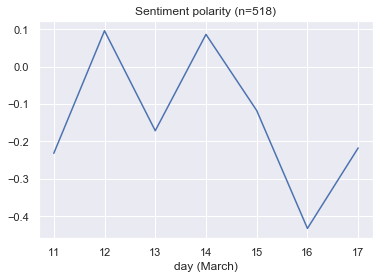

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

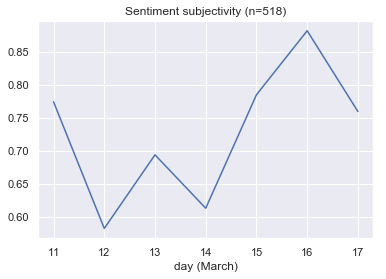

In [57]:
sentiments = df[~missing_sent]

sentiments['polarity'].groupby(sentiments.index.day).mean().plot()
plt.title(f'Sentiment polarity (n={len(sentiments)})')
plt.xlabel('day (March)')
plt.show()

sentiments['subjectivity'].groupby(sentiments.index.day).mean().plot()
plt.title(f'Sentiment subjectivity (n={len(sentiments)})')
plt.xlabel('day (March)')
plt.save
plt.show()

Make word maps for most common tokens. Here, it would be very interesting to explore looking at wordmaps of broader tweet domains. I.e. look at finance or general trending to see if corona is at the forefront of public discussion 

In [ ]:
lines = [list(TextBlob(line).words) for line in df['full_text'].values]
blobbyboy = TextBlob(' '.join(list(itertools.chain.from_iterable(lines))))
vocab = pd.Series(blobbyboy.word_counts).sort_values(ascending=False)

In [ ]:
wordcloud = WordCloud().generate_from_frequencies(frequencies=vocab.to_dict())
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Tally the hashtags mentioned in all tweets. 

In [ ]:
vocab

In [ ]:
x = pd.read_pickle('geo_COVID19_11_to_18_mixed.pkl')

In [ ]:
x[''.dropna(axis=0)

In [33]:
cols = [s for s in x.columns if 'geo' in s]

x[cols]

,geo,user.geo_enabled,retweeted_status.user.geo_enabled,retweeted_status.geo,retweeted_status.quoted_status.user.geo_enabled,retweeted_status.quoted_status.geo,quoted_status.user.geo_enabled,quoted_status.geo,geo.type,geo.coordinates,geo_latitude,geo_longitude,geo_address,geo_altitude,geo_point,geo_country
created_at,,,,,,,,,,,,,,,,
2020-03-17 23:48:31+00:00,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.818454,-1.644256,"Pamplona/Iruña, Navarra - Nafarroa, España",0.0,"42 49m 6.43368s N, 1 38m 39.3202s W",España
2020-03-17 23:46:07+00:00,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029,"Nanno, Comunità della Val di Non, Provincia di...",0.0,"46 18m 52.1114s N, 11 2m 52.9037s E",Italia
2020-03-17 23:43:13+00:00,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.419424,-2.723156,"Bermeo, Busturialdea-Urdaibai, Bizkaia, Euskad...",0.0,"43 25m 9.92712s N, 2 43m 23.3623s W",España
2020-03-17 23:37:54+00:00,NaN,False,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-17 23:35:53+00:00,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11 03:39:12+00:00,NaN,False,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11 03:32:12+00:00,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11 01:36:55+00:00,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
# stackplot of hashtag distribution

# get the hashtags
tweetblob = [TextBlob(tweet).tokenize(tokenizer) for tweet in df['full_text'].values.tolist()]
hashtags = pd.Series(itertools.chain.from_iterable(
    [[token for token in tweet if token.startswith('#')] for tweet in tweetblob]
    ))


for i in list(range(10)) + list((range(10,100,10))):
    print(f'{(hashtags.value_counts() > i).sum()} unique hashtags found with at least {i} occurrences.')
    
    
print(hashtags.value_counts().he)

1473 unique hashtags found with at least 0 occurrences.
591 unique hashtags found with at least 1 occurrences.
364 unique hashtags found with at least 2 occurrences.
248 unique hashtags found with at least 3 occurrences.
189 unique hashtags found with at least 4 occurrences.
158 unique hashtags found with at least 5 occurrences.
137 unique hashtags found with at least 6 occurrences.
115 unique hashtags found with at least 7 occurrences.
101 unique hashtags found with at least 8 occurrences.
100 unique hashtags found with at least 9 occurrences.
91 unique hashtags found with at least 10 occurrences.
59 unique hashtags found with at least 20 occurrences.
35 unique hashtags found with at least 30 occurrences.
30 unique hashtags found with at least 40 occurrences.
25 unique hashtags found with at least 50 occurrences.
24 unique hashtags found with at least 60 occurrences.
24 unique hashtags found with at least 70 occurrences.
21 unique hashtags found with at least 80 occurrences.
20 unique

In [92]:
hashtags.value_counts()

#CoronavirusOutbreak    3293
#CoronaVirusUpdates     3292
#CoronaVirusPakistan    3277
#bhaeehazirhai          3270
#COVID19                1527
                        ... 
#Skeemsaam                 1
#Haurrak                   1
#Nahibezala                1
#sakura                    1
#Juvie                     1
Length: 1473, dtype: int64